
optical-heterodyne-detection.py

c [m/s]
299792458.0

stept [s]
5.00000E-16

freq_rf [Hz]
4.00000E+11

freq1 [Hz]
1.90951E+14

freq2 [Hz]
1.93414E+14

freq diff [Hz]
-2.46388E+12



C:\Users\swako\AppData\Local\Temp\ipykernel_20632\3268950495.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  Port1_1_EFcol[ii] = Port1_1_Eout
C:\Users\swako\AppData\Local\Temp\ipykernel_20632\3268950495.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  Port1_2_EFcol[ii] = Port1_2_Eout
C:\Users\swako\AppData\Local\Temp\ipykernel_20632\3268950495.py:118: ComplexWarning: Casting complex values to real discards the imaginary part
  Port3_1_EFcol[ii] = Port3_1_Eout
C:\Users\swako\AppData\Local\Temp\ipykernel_20632\3268950495.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
  Port3_2_EFcol[ii] = Port3_2_Eout


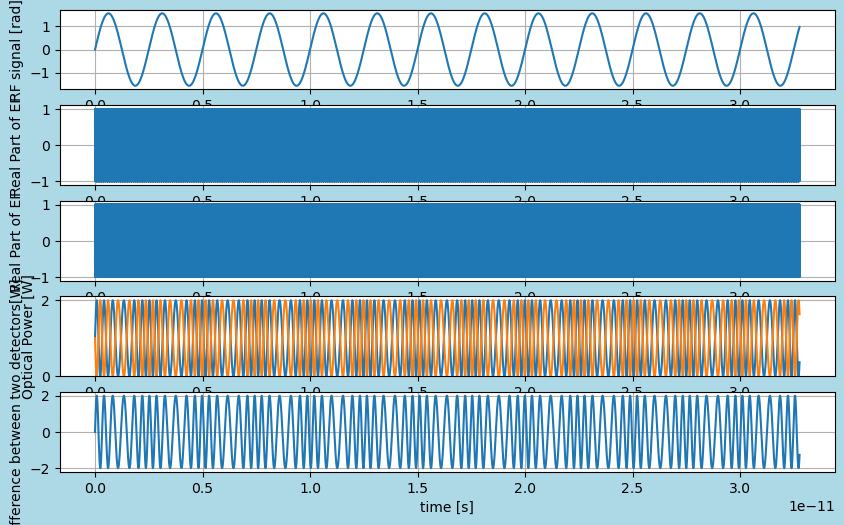

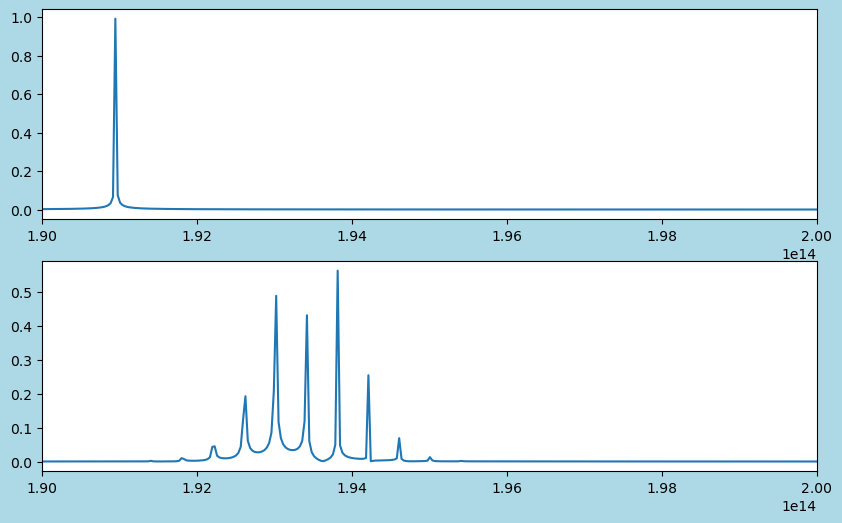

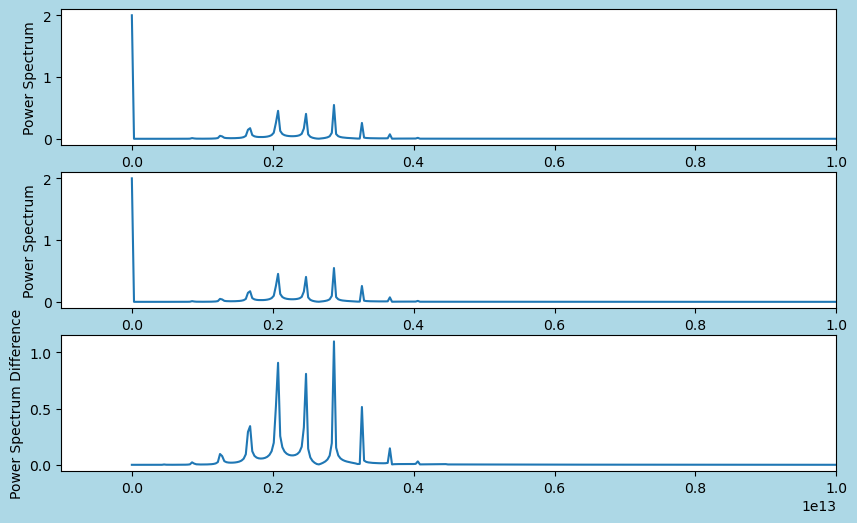

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import optical_heterodyne_detection_def
from scipy.fft import fft, fftfreq
from scipy.constants import c 

print('')
print('optical-heterodyne-detection.py')
print('')

print("c [m/s]")
print(c)
print('')

samplerate = 4*16384 # Number of Points

stept = 0.5 * 1e-15 #[s]

print("stept [s]")
print(f'{stept:.5E}')
print('')

tcol = np.linspace(0.0, stept * samplerate, samplerate, endpoint=False)

amp_c = 0.5 * np.pi
#amp_c = 0
freq_rf = 400e9 # [Hz]

print("freq_rf [Hz]")
print(f'{freq_rf:.5E}')
print('')

md = 1 # modulation depth. 1 = 100 %
dc_offset = 0 # DC offset

no = 1 # Refractive Index of medium

oplcommon1=100 #Common Path Length 1
oplcommon2=100 #Common Path Length 2

opl1 =100 
opl2= 100

wl1 = 1570e-9; #wavelength1 [m] Heterodyne
#wl1 = 1550e-9; #wavelength1 [m] Homodyne
wl2 = 1550e-9; #wavelength2 [m]

# If wl1 and wl2 are equal, homodyne. If not, heterodyne.

freq1 = c / wl1
print("freq1 [Hz]")
print(f'{freq1:.5E}')
print("")

freq2 = c / wl2
print("freq2 [Hz]")
print(f'{freq2:.5E}')
print("")

freq_diff = freq1-freq2

print("freq diff [Hz]")
print(f'{freq_diff:.5E}')
print("")


PT1 = 0.5 # PT: Power Transmission of Beam splitter

# Define Input Electric Field: Both 1 and 2 port

#Ein1 = np.array([[1+0j],[1-0j]]) 
Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
#Ein1 = np.array([[1 + 0j],[-1 - 0j]])

#tcol = np.zeros(samplerate)
signalcol = np.zeros(samplerate)

Port1_1_EFcol = np.zeros(samplerate)
Port1_2_EFcol = np.zeros(samplerate)

Port3_1_EFcol = np.zeros(samplerate)
Port3_1_powercol = np.zeros(samplerate)

Port3_2_EFcol = np.zeros(samplerate)
Port3_2_powercol = np.zeros(samplerate)

Power_diffcol = np.zeros(samplerate)


for ii in range(samplerate):
    
    t = tcol[ii]

    signal = amp_c * np.sin(2 * np.pi * freq_rf * t) + dc_offset #[rad]
    signalcol[ii] = signal  
    
    phase1 = 2*np.pi * freq1 * t # phase of local oscillator [rad]
    phase2 = 2*np.pi * freq2 * t + signal #[rad]

    Eout1 = optical_heterodyne_detection_def.propagate(phase1, phase2, Ein1)
    

    Port1_1_Eout = Eout1[0,0] # Frequency modulated
    Port1_1_EFcol[ii] = Port1_1_Eout
    
    Port1_2_Eout = Eout1[1,0] # Local Oscillator
    Port1_2_EFcol[ii] = Port1_2_Eout

    Ein2 = Eout1

    Eout2 = optical_heterodyne_detection_def.beamsplitter(PT1, Ein2)
    Ein3 = Eout2    
   
    Eout3 = optical_heterodyne_detection_def.propagate(1, 1, Ein3)
    
    #Trans
    Port3_1_Eout = Eout3[0,0]
    Port3_1_EFcol[ii] = Port3_1_Eout

    power3_1 = (np.abs(Port3_1_Eout))**2 # Optical power is calculated as squared of absolute electric field strength
    Port3_1_powercol[ii] = power3_1

    #Reflect
    Port3_2_Eout = Eout3[1,0] 
    Port3_2_EFcol[ii] = Port3_2_Eout

    power3_2 = (np.abs(Port3_2_Eout))**2
    Port3_2_powercol[ii] = power3_2
    
    # Diff
    Power_diff = power3_1 - power3_2
    Power_diffcol[ii] = Power_diff
 
 

fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax1 = fig1.add_subplot(5, 1, 1)
ax2 = fig1.add_subplot(5, 1, 2)
ax3 = fig1.add_subplot(5, 1, 3)
ax4 = fig1.add_subplot(5, 1, 4)
ax5 = fig1.add_subplot(5, 1, 5)

ax1.plot(tcol,signalcol)
#ax1.set_ylim(-3.14,3.14)
ax1.set_ylabel("RF signal [rad]")
ax1.grid()

ax2.plot(tcol,np.real(Port1_1_EFcol))
ax2.set_ylabel("Real Part of EF")
#ax2.set_ylim(-3, 3)
ax2.grid()

ax3.plot(tcol,np.real(Port1_2_EFcol))
ax3.set_ylabel("Real Part of EF")
#ax2.set_ylim(-3, 3)
ax3.grid()

ax4.plot(tcol,Port3_1_powercol,tcol,Port3_2_powercol)
ax4.set_ylabel("Optical Power [W]")
ax4.set_ylim(0,2.1)
ax4.grid()

ax5.plot(tcol,Power_diffcol)
ax5.set_xlabel("time [s]")
ax5.set_ylabel("Power Difference between two detectors[W]")
ax5.grid()


fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax2_1 = fig2.add_subplot(2, 1, 1)
ax2_2 = fig2.add_subplot(2, 1, 2)
#ax2_3 = fig2.add_subplot(4, 1, 3)
#ax2_4 = fig2.add_subplot(4, 1, 4)

xf = fftfreq(samplerate, stept)[:samplerate//2]


Port1_1_EFcol_f = fft(Port1_1_EFcol)
Port1_2_EFcol_f = fft(Port1_2_EFcol)

ax2_1.plot(xf, 2.0/samplerate * np.abs(Port1_1_EFcol_f[0:samplerate//2]))
ax2_1.set_xlim(190e12,200e12)

ax2_2.plot(xf, 2.0/samplerate * np.abs(Port1_2_EFcol_f[0:samplerate//2]))
ax2_2.set_xlim(190e12,200e12)

fig3 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax3_1 = fig3.add_subplot(3, 1, 1)
ax3_2 = fig3.add_subplot(3, 1, 2)
ax3_3 = fig3.add_subplot(3, 1, 3)

Port1_powercol_f = fft(Port3_1_powercol)
Port2_powercol_f = fft(Port3_2_powercol)

ax3_1.plot(xf, 2.0/samplerate * np.abs(Port1_powercol_f[0:samplerate//2]))
ax3_1.set_ylabel("Power Spectrum")
ax3_1.set_xlim(-1e12,10e12)

ax3_2.plot(xf, 2.0/samplerate * np.abs(Port2_powercol_f[0:samplerate//2]))
ax3_2.set_ylabel("Power Spectrum")
ax3_2.set_xlim(-1e12,10e12)

Power_diffcol_f = fft(Power_diffcol)
ax3_3.plot(xf, 2.0/samplerate * np.abs(Power_diffcol_f[0:samplerate//2]))
ax3_3.set_ylabel("Power Spectrum Difference")
ax3_3.set_xlim(-1e12,10e12)

plt.show()

